Mean of $N$ variables $\cal{N}(0, \sigma)$ is $\cal{N}(0, \sigma/\sqrt{n})$

In [1]:
from mangaki.models import Profile

In [4]:
from collections import Counter

Counter(Profile.objects.values_list('is_shared', flat=True))

Counter({False: 92, True: 7950})

In [5]:
92/(7950+92)

0.011439940313354886

In [13]:
Counter(list(Profile.objects.values_list('is_shared', 'research_ok')))

Counter({(False, True): 78,
         (True, True): 7833,
         (False, False): 14,
         (True, False): 117})

In [368]:
Profile.objects.filter(is_shared=False, research_ok=True).order_by('?').values('user')[:1]

<QuerySet [{'user': 372}]>

In [433]:
PRIVATE_USER = 372

In [434]:
df_private = pd.DataFrame(
    User.objects.get(id=372).rating_set.values_list('work_id', 'choice'),
    columns=('item_id', 'choice')).sort_values('item_id')

In [435]:
len(df_private)

417

In [436]:
import pandas as pd

df = pd.DataFrame(Rating.objects.exclude(user_id=PRIVATE_USER).filter(
    # user__profile__is_shared=False,
    user__profile__research_ok=True,
    work__in=df_private['item_id']).values_list(
    'user_id', 'work_id', 'choice'), columns=('user_id', 'item_id', 'choice'))

In [437]:
df.head(), len(df)

(   user_id  item_id   choice
 0      169        1     like
 1      229        1     like
 2      224        1     like
 3      278        1  willsee
 4      234        1  dislike,
 61684)

In [444]:
item_ids, cols = np.unique(df['item_id'], return_inverse=True)
encode_col = dict(zip(df['item_id'], cols))

In [445]:
len(item_ids), len(cols)

(417, 61684)

In [447]:
from mangaki.utils.values import rating_values
import numpy as np

df['row'] = np.unique(df['user_id'], return_inverse=True)[1]
df['col'] = np.unique(df['item_id'], return_inverse=True)[1]
df['value'] = df['choice'].map(rating_values)

In [448]:
df_private['value'] = df_private['choice'].map(rating_values)
df_private['col'] = df_private['item_id'].map(encode_col)

In [449]:
from sklearn.model_selection import train_test_split

In [450]:
private_train, private_test = train_test_split(df_private, test_size=0.2, shuffle=True)

In [452]:
private_train = private_train.sort_values('col')
private_test = private_test.sort_values('col')

In [453]:
train = np.array(private_train['col'])
test = np.array(private_test['col'])

In [454]:
df.head()

,user_id,item_id,choice,row,col,value
0,169,1,like,139,0,2.0
1,229,1,like,189,0,2.0
2,224,1,like,184,0,2.0
3,278,1,willsee,231,0,0.5
4,234,1,dislike,194,0,-2.0


In [455]:
df[['item_id', 'col']].drop_duplicates().sort_values('item_id')

,item_id,col
0,1,0
1751,2,1
2984,4,2
4450,5,3
6074,6,4
...,...,...
61157,8012,412
61459,8019,413
61466,8050,414
61572,8051,415


In [456]:
from scipy.sparse import csr_matrix

M = csr_matrix((df['value'], (df['row'], df['col'])))

In [457]:
M

<2156x417 sparse matrix of type '<class 'numpy.float64'>'
	with 61684 stored elements in Compressed Sparse Row format>

In [458]:
from sklearn.linear_model import LinearRegression

In [459]:
truth = np.array(df_private['value'])
train_truth = np.array(private_train['value'])
test_truth = np.array(private_test['value'])

In [460]:
lr = LinearRegression()
lr.fit(M.T[train], train_truth)

LinearRegression()

In [461]:
lr2 = LinearRegression()

In [462]:
lr3 = LinearRegression()

In [463]:
pred = lr.predict(M.T)

In [464]:
weights[:10]

array([0.02075742, 0.02075742, 0.02075742, 0.02075742, 0.02075742,
       0.02075742, 0.02075742, 0.02075742, 0.02075742, 0.02075742])

In [465]:
rating_values

{'favorite': 4,
 'like': 2,
 'dislike': -2,
 'neutral': 0.1,
 'willsee': 0.5,
 'wontsee': -0.5}

In [467]:
def loss_f(true, pred):
    pred = np.clip(pred, -2, 4)
    return ((np.round(pred, 3) - true) ** 2).mean()

In [476]:
%%time
y = []
x = [5, 10, 15, 20, 30, 50, 100]
y_knn = []  # Train losses
y_lr_knn = []
y_lr = []
y_w_knn = []
test_untrained_lr = []
test_knn = []  # Test losses
test_lr = []
test_lr_knn = []
test_w_knn = []

for KEEP in x:
    truncated = np.abs(lr.coef_).argsort()[-KEEP:]
    train_approx = M.T[train][:, truncated] @ lr.coef_[truncated] + lr.intercept_
    test_approx = M.T[test][:, truncated] @ lr.coef_[truncated] + lr.intercept_
    train_loss = loss_f(train_truth, train_approx)
    test_loss = loss_f(test_truth, test_approx)
    y.append(train_loss)
    test_untrained_lr.append(test_loss)
    
    lr3.fit(M.T[train][:, truncated], train_truth)
    train_approx = lr3.predict(M.T[train][:, truncated])
    test_approx = lr3.predict(M.T[test][:, truncated])
    train_loss = loss_f(train_truth, train_approx)
    test_loss = loss_f(test_truth, test_approx)
    y_lr.append(train_loss)
    test_lr.append(test_loss)
    
    truncated = neighbors[:KEEP].reshape(-1)
    lr2.fit(M.T[train][:, truncated], train_truth)
    train_approx = lr2.predict(M.T[train][:, truncated])
    test_approx = lr2.predict(M.T[test][:, truncated])
    train_loss = loss_f(train_truth, train_approx)
    test_loss = loss_f(test_truth, test_approx)
    y_lr_knn.append(train_loss)
    test_lr_knn.append(test_loss)
    
    train_approx = M.T[train][:, truncated].mean(axis=1).A1.reshape(-1)
    test_approx = M.T[test][:, truncated].mean(axis=1).A1.reshape(-1)
    train_loss = loss_f(train_truth, train_approx)
    test_loss = loss_f(test_truth, test_approx)
    y_knn.append(train_loss)
    test_knn.append(test_loss)
    
    weights = 1 - dist[:KEEP]
    train_approx = (M.T[train][:, truncated] * diags(weights)).sum(axis=1).A1.reshape(-1) / weights.sum()
    test_approx = (M.T[test][:, truncated] * diags(weights)).sum(axis=1).A1.reshape(-1) / weights.sum()
    train_loss = loss_f(train_truth, train_approx)
    test_loss = loss_f(test_truth, test_approx)
    y_w_knn.append(train_loss)
    test_w_knn.append(test_loss)

CPU times: user 174 ms, sys: 5.43 ms, total: 179 ms
Wall time: 178 ms


Text(0.5, 1.0, 'Train error for one private user')

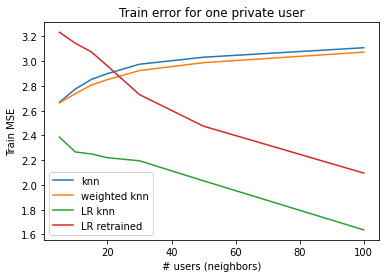

In [477]:
#plt.plot(x, y, label='LR not retrained')
plt.plot(x, y_knn, label='knn')
plt.plot(x, y_w_knn, label='weighted knn')
plt.plot(x, y_lr_knn, label='LR knn')
plt.plot(x, y_lr, label='LR retrained')
#plt.xlim(xmax=500)
#plt.ylim(ymax=5)
plt.legend()
plt.xlabel('# users (neighbors)')
plt.ylabel('Train MSE')
plt.title('Train error for one private user')

Text(0.5, 1.0, 'Test error for one private user')

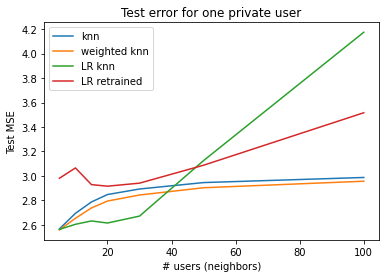

In [478]:
#plt.plot(x, test_untrained_lr, label='LR not retrained')
plt.plot(x, test_knn, label='knn')
plt.plot(x, test_w_knn, label='weighted knn')
plt.plot(x, test_lr_knn, label='LR knn')
plt.plot(x, test_lr, label='LR retrained')
#plt.xlim(xmax=500)
#plt.ylim(ymax=5)
plt.legend()
plt.xlabel('# users (neighbors)')
plt.ylabel('Test MSE')
plt.title('Test error for one private user')

(array([   6.,   18.,   48.,  257., 1521.,  178.,   36.,   16.,    6.,
           6.]),
 array([-0.10496153, -0.0811011 , -0.05724068, -0.03338026, -0.00951983,
         0.01434059,  0.03820101,  0.06206144,  0.08592186,  0.10978228,
         0.13364271]),
 <BarContainer object of 10 artists>)

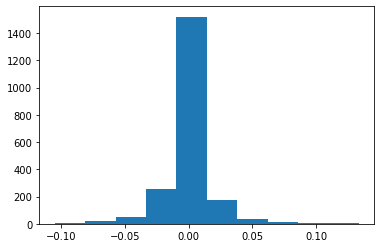

In [151]:
import matplotlib.pyplot as plt

plt.hist(lr.coef_)

In [128]:
best_pos = lr.coef_.argsort()[-5:]

In [129]:
best_pos

array([  39,   76,  180, 1176,  475])

In [130]:
lr.coef_[best_pos]

array([0.11645822, 0.11968056, 0.1199534 , 0.12968687, 0.13364271])

In [134]:
df.query("row == 475")

,user_id,item_id,choice,row,col,value
9362,557,7,like,475,0,2.0
9363,557,80,dislike,475,13,-2.0
9364,557,742,willsee,475,38,0.5
9365,557,954,like,475,44,2.0
9366,557,1377,wontsee,475,52,-0.5
...,...,...,...,...,...,...
36730,557,2040,neutral,475,71,0.1
36898,557,2078,wontsee,475,75,-0.5
37111,557,410,like,475,31,2.0
40196,557,151,willsee,475,23,0.5


In [175]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(np.array(df_private['value']).reshape(1, -1), M)

In [176]:
sim.argsort()[:, -5:]

array([[ 106,  241, 1208,   76,  343]])

In [177]:
(M[343].toarray()[0] == truth).mean()

0.3728813559322034

In [178]:
(M[343].toarray()[0] == 0).mean()

0.4491525423728814

In [468]:
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors

knn = NearestNeighbors(n_neighbors=1000, metric='cosine')
knn.fit(M[:, train])

dist, neighbors = knn.kneighbors(train_truth.reshape(1, -1))
dist = dist[0]
neighbors = neighbors[0]

In [410]:
neighbors[:5]

array([1434, 1555,  117, 1562,  114])

In [411]:
1 - M[343] @ truth / (np.linalg.norm(truth) * np.linalg.norm(M[343].toarray()))

array([0.86179229])

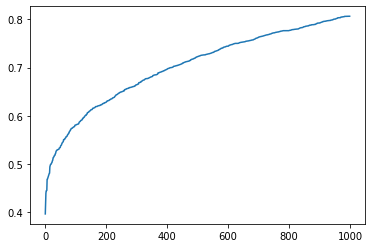

In [232]:
plt.plot(dist[0])

In [236]:
neighbors.shape

(1, 1000)

In [479]:
2.6 ** 0.5

1.61245154965971